# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
# sys.path.append("../../../")
import copy

In [2]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver, TrapMetric
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f6e7f097490>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../input_files/tetramer_rategrowth.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['monomer_add_only', True]
['homo_rates', True]
['A']
100.0
['M']
100.0
['B']
100.0
['S']
100.0
Parsing rule...
SPLIT_01:  ['A(a)+B(b)', 'A(a!1).B(a!1)']
['A', 'B', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(b)+M(a)', 'A(b!1).M(a!1)']
['A', 'M', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(c)+S(a)', 'A(c!1).S(a!1)']
['A', 'S', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(b)+M(b)', 'B(b!1).M(b!1)']
['B', 'M', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(c)+S(b)', 'B(c!1).S(b!1)']
['B', 'S', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['M(c)+S(b)', 'M(c!1).S(b!1)']
['M', 'S', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7432190>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7432190>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <netwo

Node-1 :  (6, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7436810>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
Node-2 :  (4, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7436110>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
-----
{'A', 'S'}
{'A', 'M'}
{'S'}
Steric hindrance detected
Node-1 :  (6, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7436810>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
Node-2 :  (5, {'struct': <networkx.classes.graph.Graph object at 0x7f6dff2611d0>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
-----
{'A', 'S'}
{'A', 'B'}
{'S'}
Steric hindrance detected
Node-1 :  (6, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7436810>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
Node-2 :  (6, {'struct': <networkx.classes.graph.Graph object at 0x7f6da7436810>, 'copies': tensor([0.], dtype=torch.float64), 'subunits': 2})
-----
{'A', 'S'}
{'A',

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,'--',gtostr(rn.network.nodes[n]['struct']))
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 16, (0, 10): 17, (0, 12): 18, (0, 14): 21, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 19, (1, 14): 20, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (5, 9): 5, (5, 12): 13, (6, 10): 6, (6, 12): 9, (7, 13): 14, (7, 9): 16, (8, 13): 10, (8, 10): 17, (9, 14): 15, (10, 14): 11, (11, 12): 18, (11, 13): 19, (12, 14): 20, (13, 14): 21}


In [5]:
#Do modifications here
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1.]*np.array(2e0))
new_kon[0]=1.0
# par_kon = [4.0506, 0.0127, 3.4233, 2.8482]
# counter=0
# for cls,uids in rn.rxn_class.items():
#     new_kon[uids]=par_kon[counter]
#     counter+=1

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

#Changing initial concentrations

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 16}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 17}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 18}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 4}
{'k_on

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [6]:
# vec_rn.update_reaction_net(rn)
# poly_system = EquilibriumSolver(rn)
# solution = poly_system.solve()
# print(solution)
# if solution == None:
#     print("No Equilibrium solution")
# else:
#     print(solution)
#     print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
# print(vec_rn.kon)

In [7]:
# uid_dict = {}
# sys.path.append("../")
# import numpy as np
# from reaction_network import gtostr
# from torch import DoubleTensor as Tensor

# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         if len(edges)==0:
#             return(False)
#         kon_max = -1
#         next_node = -1
        
#         kon_sum = 0
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']
#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
# #             #Calculate k_off also
# #             std_c = Tensor([1.])
# #             l_kon = torch.log(temp_kon)
# #             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (self._R * self._T)) + l_kon + torch.log(std_c)
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]

# print(pathway)
# print(kon_sumarray)
# #print(total_con_rate)

In [8]:
# if solution != None:
#     for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#         print(k," : ", v.item())

In [9]:
# if solution !=None:
#     for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#         print(k," : ", v)

## Using the optimizer with a 1 second simulation runtime ##

In [10]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=1000,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop")
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1,conc_thresh=1,mod_bool=True,mod_factor=10,max_thresh=100,max_yield=0)

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 2., 2.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Start of simulation: memory Used:  48.8
Next time:  tensor(16.3344, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 0 was 39.9%
current params: tensor([1., 2., 2.], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.8
Next time:  tensor(20.8684, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1 was 44.9%
current params: tensor([0.9000, 2.1000, 2.1000], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  48.9
Next time:  tensor(27.9311, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2 was 49.2%
current params: tensor([0.8221, 2.1745, 2.1713], dtype=torch.float64)
Usin

Next time:  tensor(18.4008, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 35 was 44.6%
current params: tensor([0.9260, 1.9625, 2.2409], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.4
Next time:  tensor(18.3850, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 36 was 44.6%
current params: tensor([0.9254, 1.9628, 2.2424], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.4
Next time:  tensor(18.4083, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 37 was 44.6%
current params: tensor([0.9268, 1.9611, 2.2419], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.5
Next time:  tensor(18.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 38 was 44.6%
current params: tensor([0.9262, 1.9614, 2.2434], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  50.5
Next time:  tensor(18.3751, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on si

Next time:  tensor(12.3781, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 71 was 38.0%
current params: tensor([1.0680, 1.8185, 2.1069], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.9
Next time:  tensor(12.3824, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 72 was 38.0%
current params: tensor([1.0688, 1.8175, 2.1060], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  51.9
Next time:  tensor(12.8423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 73 was 37.8%
current params: tensor([1.0748, 1.8107, 2.0998], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.0
Next time:  tensor(12.9112, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 74 was 37.8%
current params: tensor([1.0748, 1.8106, 2.0998], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  52.0
Next time:  tensor(13.0610, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on si

Next time:  tensor(14.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 107 was 40.8%
current params: tensor([1.0062, 1.8843, 2.1714], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.4
Next time:  tensor(14.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 108 was 40.8%
current params: tensor([1.0062, 1.8843, 2.1714], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.5
Next time:  tensor(14.3424, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 109 was 40.8%
current params: tensor([1.0062, 1.8843, 2.1714], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.5
Next time:  tensor(14.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 110 was 40.8%
current params: tensor([1.0062, 1.8843, 2.1714], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  53.5
Next time:  tensor(14.3421, dtype=torch.float64, grad_fn=<AddBackward0>)
yield o

Next time:  tensor(14.3397, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 143 was 40.8%
current params: tensor([1.0068, 1.8841, 2.1721], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  54.9
Next time:  tensor(14.3395, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 144 was 40.8%
current params: tensor([1.0067, 1.8841, 2.1721], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  55.0
Next time:  tensor(14.3395, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 145 was 40.8%
current params: tensor([1.0068, 1.8841, 2.1722], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  55.0
Next time:  tensor(14.3395, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 146 was 40.8%
current params: tensor([1.0068, 1.8841, 2.1722], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  55.0
Next time:  tensor(14.3392, dtype=torch.float64, grad_fn=<AddBackward0>)
yield o

Using CPU
Start of simulation: memory Used:  56.4
Next time:  tensor(14.2825, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 179 was 41.2%
current params: tensor([0.9980, 1.8923, 2.1820], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.5
Next time:  tensor(14.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 180 was 41.2%
current params: tensor([0.9981, 1.8922, 2.1819], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.5
Next time:  tensor(14.2827, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 181 was 41.2%
current params: tensor([0.9981, 1.8922, 2.1820], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.6
Next time:  tensor(14.2825, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 182 was 41.2%
current params: tensor([0.9980, 1.8922, 2.1820], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  56.6
Next time:  tensor(14.2822, dt

Using CPU
Start of simulation: memory Used:  58.1
Next time:  tensor(16.7955, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 215 was 43.6%
current params: tensor([0.9487, 1.9376, 2.2312], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.2
Next time:  tensor(16.7950, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 216 was 43.6%
current params: tensor([0.9486, 1.9376, 2.2313], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.2
Next time:  tensor(16.7945, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 217 was 43.6%
current params: tensor([0.9486, 1.9376, 2.2313], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.3
Next time:  tensor(16.7940, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 218 was 43.6%
current params: tensor([0.9486, 1.9376, 2.2314], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  58.3
Next time:  tensor(16.7935, dt

Using CPU
Start of simulation: memory Used:  59.5
Next time:  tensor(18.0921, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 251 was 45.6%
current params: tensor([0.9093, 1.9718, 2.2702], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.5
Next time:  tensor(18.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 252 was 45.5%
current params: tensor([0.9096, 1.9715, 2.2699], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.5
Next time:  tensor(18.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 253 was 45.6%
current params: tensor([0.9095, 1.9716, 2.2700], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.6
Next time:  tensor(18.0967, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 254 was 45.5%
current params: tensor([0.9096, 1.9715, 2.2699], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  59.6
Next time:  tensor(18.0960, dt

Using CPU
Start of simulation: memory Used:  61.0
Next time:  tensor(19.9024, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 287 was 46.4%
current params: tensor([0.8932, 1.9846, 2.2868], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.1
Next time:  tensor(19.9019, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 288 was 46.4%
current params: tensor([0.8932, 1.9846, 2.2868], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.1
Next time:  tensor(19.9009, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 289 was 46.4%
current params: tensor([0.8932, 1.9847, 2.2869], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.2
Next time:  tensor(19.8998, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 290 was 46.4%
current params: tensor([0.8931, 1.9847, 2.2870], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  61.2
Next time:  tensor(19.8993, dt

Using CPU
Start of simulation: memory Used:  62.7
Next time:  tensor(23.9642, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 323 was 49.1%
current params: tensor([0.8405, 2.0263, 2.3367], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.7
Next time:  tensor(23.9618, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 324 was 49.2%
current params: tensor([0.8405, 2.0263, 2.3368], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.7
Next time:  tensor(23.9594, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 325 was 49.2%
current params: tensor([0.8404, 2.0263, 2.3369], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.8
Next time:  tensor(23.9719, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 326 was 49.1%
current params: tensor([0.8408, 2.0261, 2.3367], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  62.8
Next time:  tensor(23.9693, dt

Using CPU
Start of simulation: memory Used:  64.5
Next time:  tensor(23.7361, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 359 was 49.5%
current params: tensor([0.8349, 2.0319, 2.3449], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.5
Next time:  tensor(23.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 360 was 49.5%
current params: tensor([0.8353, 2.0315, 2.3446], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.5
Next time:  tensor(23.7483, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 361 was 49.5%
current params: tensor([0.8353, 2.0315, 2.3446], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.5
Next time:  tensor(23.7673, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 362 was 49.4%
current params: tensor([0.8359, 2.0310, 2.3441], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  64.5
Next time:  tensor(23.7651, dt

Using CPU
Start of simulation: memory Used:  66.0
Next time:  tensor(23.8546, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 395 was 49.3%
current params: tensor([0.8392, 2.0278, 2.3434], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.0
Next time:  tensor(23.8607, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 396 was 49.3%
current params: tensor([0.8394, 2.0276, 2.3433], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.1
Next time:  tensor(23.8580, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 397 was 49.3%
current params: tensor([0.8393, 2.0277, 2.3435], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.1
Next time:  tensor(24.0187, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 398 was 49.1%
current params: tensor([0.8428, 2.0249, 2.3404], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  66.1
Next time:  tensor(24.0124, dt

Using CPU
Start of simulation: memory Used:  68.2
Next time:  tensor(19.8887, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 431 was 46.3%
current params: tensor([0.8949, 1.9806, 2.2936], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.3
Next time:  tensor(19.8878, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 432 was 46.3%
current params: tensor([0.8949, 1.9806, 2.2937], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.3
Next time:  tensor(19.8869, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 433 was 46.3%
current params: tensor([0.8949, 1.9807, 2.2937], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.3
Next time:  tensor(19.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 434 was 46.3%
current params: tensor([0.8948, 1.9807, 2.2938], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  68.4
Next time:  tensor(19.8875, dt

Using CPU
Start of simulation: memory Used:  69.9
Next time:  tensor(21.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 467 was 48.6%
current params: tensor([0.8534, 2.0224, 2.3372], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.9
Next time:  tensor(21.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 468 was 48.6%
current params: tensor([0.8535, 2.0222, 2.3371], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.6
Next time:  tensor(21.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 469 was 48.6%
current params: tensor([0.8535, 2.0223, 2.3372], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.7
Next time:  tensor(21.3373, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 470 was 48.6%
current params: tensor([0.8534, 2.0223, 2.3373], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  69.6
Next time:  tensor(21.3394, dt

Using CPU
Start of simulation: memory Used:  70.8
Next time:  tensor(19.6110, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 503 was 47.1%
current params: tensor([0.8828, 1.9938, 2.3101], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.8
Next time:  tensor(19.6100, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 504 was 47.1%
current params: tensor([0.8828, 1.9939, 2.3102], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.8
Next time:  tensor(19.6107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 505 was 47.1%
current params: tensor([0.8829, 1.9938, 2.3102], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.8
Next time:  tensor(19.6097, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 506 was 47.1%
current params: tensor([0.8828, 1.9938, 2.3103], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  70.9
Next time:  tensor(19.6113, dt

Using CPU
Start of simulation: memory Used:  72.4
Next time:  tensor(23.2661, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 539 was 50.2%
current params: tensor([0.8264, 2.0485, 2.3682], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.5
Next time:  tensor(23.2642, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 540 was 50.2%
current params: tensor([0.8264, 2.0486, 2.3683], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.5
Next time:  tensor(23.2623, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 541 was 50.2%
current params: tensor([0.8263, 2.0486, 2.3684], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.6
Next time:  tensor(23.2604, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 542 was 50.2%
current params: tensor([0.8263, 2.0486, 2.3685], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  72.6
Next time:  tensor(23.2643, dt

Using CPU
Start of simulation: memory Used:  74.2
Next time:  tensor(31.8111, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 575 was 54.0%
current params: tensor([0.7614, 2.1072, 2.4328], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.3
Next time:  tensor(31.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 576 was 54.0%
current params: tensor([0.7616, 2.1070, 2.4327], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.3
Next time:  tensor(31.8413, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 577 was 54.0%
current params: tensor([0.7618, 2.1068, 2.4325], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.4
Next time:  tensor(31.8365, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 578 was 54.0%
current params: tensor([0.7618, 2.1068, 2.4326], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  74.4
Next time:  tensor(31.8318, dt

Using CPU
Start of simulation: memory Used:  76.0
Next time:  tensor(23.7382, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 611 was 49.3%
current params: tensor([0.8417, 2.0321, 2.3565], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.0
Next time:  tensor(23.7370, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 612 was 49.3%
current params: tensor([0.8417, 2.0321, 2.3565], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.1
Next time:  tensor(23.7358, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 613 was 49.3%
current params: tensor([0.8417, 2.0321, 2.3566], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.1
Next time:  tensor(23.7342, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 614 was 49.3%
current params: tensor([0.8416, 2.0322, 2.3567], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  76.2
Next time:  tensor(23.7327, dt

Using CPU
Start of simulation: memory Used:  78.9
Next time:  tensor(21.2383, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 647 was 48.8%
current params: tensor([0.8513, 2.0209, 2.3478], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.2
Next time:  tensor(21.2373, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 648 was 48.8%
current params: tensor([0.8513, 2.0209, 2.3478], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.4
Next time:  tensor(21.2363, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 649 was 48.8%
current params: tensor([0.8512, 2.0209, 2.3479], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.1
Next time:  tensor(21.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 650 was 48.8%
current params: tensor([0.8513, 2.0208, 2.3479], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  78.2
Next time:  tensor(21.2371, dt

Using CPU
Start of simulation: memory Used:  79.1
Next time:  tensor(21.7539, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 683 was 47.7%
current params: tensor([0.8705, 1.9990, 2.3293], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.1
Next time:  tensor(21.7563, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 684 was 47.7%
current params: tensor([0.8705, 1.9989, 2.3293], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.1
Next time:  tensor(21.7673, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 685 was 47.7%
current params: tensor([0.8708, 1.9986, 2.3291], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.2
Next time:  tensor(21.7655, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 686 was 47.7%
current params: tensor([0.8707, 1.9987, 2.3292], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  79.2
Next time:  tensor(21.7760, dt

Using CPU
Start of simulation: memory Used:  80.0
Next time:  tensor(19.6198, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 719 was 47.0%
current params: tensor([0.8838, 1.9835, 2.3172], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.1
Next time:  tensor(13.6782, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 720 was 47.6%
current params: tensor([0.8758, 1.9929, 2.3258], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.1
Next time:  tensor(13.3032, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 721 was 47.6%
current params: tensor([0.8757, 1.9930, 2.3259], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.2
Next time:  tensor(19.5684, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 722 was 47.2%
current params: tensor([0.8814, 1.9864, 2.3200], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  80.2
Next time:  tensor(19.5728, dt

Using CPU
Start of simulation: memory Used:  82.4
Next time:  tensor(21.6238, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 755 was 47.9%
current params: tensor([0.8676, 2.0019, 2.3366], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.3
Next time:  tensor(21.6272, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 756 was 47.9%
current params: tensor([0.8677, 2.0017, 2.3366], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.4
Next time:  tensor(21.6306, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 757 was 47.9%
current params: tensor([0.8679, 2.0015, 2.3365], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.4
Next time:  tensor(21.6289, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 758 was 47.9%
current params: tensor([0.8678, 2.0016, 2.3366], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  82.5
Next time:  tensor(21.6272, dt

Using CPU
Start of simulation: memory Used:  88.5
Next time:  tensor(19.5189, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 791 was 47.3%
current params: tensor([0.8802, 1.9865, 2.3259], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.7
Next time:  tensor(19.5174, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 792 was 47.3%
current params: tensor([0.8802, 1.9865, 2.3260], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(19.5186, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 793 was 47.3%
current params: tensor([0.8802, 1.9864, 2.3260], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(19.5209, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 794 was 47.3%
current params: tensor([0.8804, 1.9862, 2.3259], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.7
Next time:  tensor(19.5233, dt

Using CPU
Start of simulation: memory Used:  86.9
Next time:  tensor(37.6118, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 827 was 58.5%
current params: tensor([0.6964, 2.1694, 2.5118], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  86.9
Next time:  tensor(37.6059, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 828 was 58.5%
current params: tensor([0.6964, 2.1695, 2.5119], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.0
Next time:  tensor(37.5999, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 829 was 58.5%
current params: tensor([0.6963, 2.1695, 2.5120], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.0
Next time:  tensor(37.5939, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 830 was 58.5%
current params: tensor([0.6962, 2.1695, 2.5121], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  87.1
Next time:  tensor(37.6147, dt

Using CPU
Start of simulation: memory Used:  88.2
Next time:  tensor(147.0583, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 863 was 77.5%
current params: tensor([0.4573, 2.3669, 2.7339], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.2
Next time:  tensor(147.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 864 was 77.5%
current params: tensor([0.4573, 2.3669, 2.7340], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.6
Next time:  tensor(146.9830, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 865 was 77.5%
current params: tensor([0.4573, 2.3669, 2.7340], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.7
Next time:  tensor(146.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 866 was 77.5%
current params: tensor([0.4572, 2.3669, 2.7340], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  88.7
Next time:  tensor(176.889

Using CPU
Start of simulation: memory Used:  89.7
Next time:  tensor(1.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 899 was 97.6%
current params: tensor([0.2408, 2.5039, 2.9169], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  89.9
Next time:  tensor(1.1053, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 900 was 97.6%
current params: tensor([0.2408, 2.5039, 2.9169], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  89.9
Next time:  tensor(1.1054, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 901 was 97.6%
current params: tensor([0.2408, 2.5039, 2.9169], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.0
Next time:  tensor(1.1055, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 902 was 97.6%
current params: tensor([0.2408, 2.5039, 2.9169], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.1
Next time:  tensor(1.1056, dtype=t

Using CPU
Start of simulation: memory Used:  90.7
Next time:  tensor(1.1087, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 935 was 97.7%
current params: tensor([0.2404, 2.5041, 2.9173], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.7
Next time:  tensor(1.1088, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 936 was 97.7%
current params: tensor([0.2403, 2.5041, 2.9173], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.8
Next time:  tensor(1.1090, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 937 was 97.7%
current params: tensor([0.2403, 2.5041, 2.9173], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.7
Next time:  tensor(1.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 938 was 97.7%
current params: tensor([0.2403, 2.5041, 2.9173], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  90.8
Next time:  tensor(1.1092, dtype=t

Using CPU
Start of simulation: memory Used:  91.5
Next time:  tensor(1.1131, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 971 was 97.7%
current params: tensor([0.2398, 2.5043, 2.9177], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  91.5
Next time:  tensor(1.1133, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 972 was 97.7%
current params: tensor([0.2398, 2.5043, 2.9177], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  91.6
Next time:  tensor(1.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 973 was 97.7%
current params: tensor([0.2398, 2.5043, 2.9177], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  91.6
Next time:  tensor(1.1136, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 974 was 97.7%
current params: tensor([0.2398, 2.5043, 2.9177], dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  91.7
Next time:  tensor(1.1137, dtype=t

In [11]:
# optim.optimize()

In [12]:
# optim.optimize()

In [13]:
# optim.optimize()

In [14]:
def calc_var(v1,v2):
    sq_sum=0
    for i in range(len(v1)):
        sq_sum=(v1[i]-v2[i])**2+sq_sum
    
    sq_sum = ((sq_sum)**0.5)/(len(v1)-1)
    return(sq_sum)

In [15]:
yields= []
final_params=[]
asymm = []
final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []
for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
    final_params.append(optim.final_solns[i].numpy())
    
    if type(optim.final_t50[i])==int:
        final_t50.append(1) 
    else:
        final_t50.append(optim.final_t50[i].item()) 
    if type(optim.final_t85[i])==int:
        final_t85.append(1) 
    else:
        final_t85.append(optim.final_t85[i].item()) 
    if type(optim.final_t95[i])==int:
        final_t95.append(1)
    else:
        final_t95.append(optim.final_t95[i].item())


sort_indx=np.argsort(np.array(yields))
sorted_yields=np.array(yields)#[sort_indx]
sorted_params = np.array(final_params)#[sort_indx]

sorted_t50 = np.array(final_t50)#[sort_indx]
sorted_t85 = np.array(final_t85)#[sort_indx]
sorted_t95 = np.array(final_t95)#[sort_indx]


print("Max Yield: ",sorted_yields[-1],"\nParams: ",sorted_params[-1])


Max Yield:  0.9778620032475455 
Params:  [0.23931736 2.50451811 2.9180899 ]


In [16]:
#Writing all solutions to a file

klabels=['k'+str(i) for i in range(len(vec_rn.kon))]
header = '#Yield\t' + "\t".join(klabels) + "\tt50\tt85\tt95\n"


with open("Tetramer_Solutions_Irreversible_RING",'w') as fl:
    fl.write(header)
    for i in range(1,len(sorted_yields)-1):
        fl.write("%f" %(sorted_yields[i]))
        
        for j in range((sorted_params[i-1].shape[0])):
            
            fl.write("\t%f" %(sorted_params[i-1][j]))
        fl.write("\t%f\t%f\t%f\n" %(sorted_t50[i],sorted_t85[i],sorted_t95[i]))

In [17]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off']}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
M
B
S
AM
AB
AS
BM
MS
ABM
AMS
BS
ABS
BMS
ABMS
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'M'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557}
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 2.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.004122307244877107}
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'S'}), 'kon': 2.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.004122307244877107}
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'M'}, {'B'}), 'kon': 2.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.004122307244877107}
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'M'}, {'S'}), 'kon': 2.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.004122307244877107}
tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBa

In [18]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (self._R * self._T)) + l_kon + torch.log(std_c)
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

pathway = []
kon_sumarray = []
total_con_rate = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]

print(pathway)
print(kon_sumarray)
#print(total_con_rate)

[['A', 'ABMS'], ['M', 'ABMS'], ['B', 'ABMS'], ['S', 'ABMS'], ['AM', 'ABM', 'ABMS'], ['AB', 'ABM', 'ABMS'], ['AS', 'AMS', 'ABMS'], ['BM', 'BMS', 'ABMS'], ['MS', 'BMS', 'ABMS'], ['ABM', 'ABMS'], ['AMS', 'ABMS'], ['BS', 'ABS', 'ABMS'], ['ABS', 'ABMS'], ['BMS', 'ABMS'], ['ABMS']]
[2.918103770977784, 2.918103770977784, 2.918103770977784, 2.918103770977784, 5.422628731730441, 5.422628731730441, 5.422628731730441, 5.422628731730441, 5.422628731730441, 2.918103770977784, 2.918103770977784, 5.422628731730441, 2.918103770977784, 2.918103770977784, 0]


In [19]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

ABM  :  2.918103770977784
AMS  :  2.918103770977784
BMS  :  2.918103770977784
ABS  :  2.918103770977784
AM  :  5.009049921505313
AB  :  5.009049921505313
AS  :  5.009049921505313
BM  :  5.009049921505313
MS  :  5.009049921505313
BS  :  5.009049921505313
A  :  11.149577978632749
M  :  11.149577978632749
B  :  11.149577978632749
S  :  11.149577978632749


Let's first visualize some of the data.

**Without any optimization**


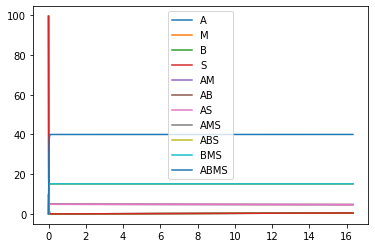

In [20]:
nodes_list = ['A','B','S','M','AB','BMS','ABS','AMS','ABMS','AM','AS']
#nodes_list = ['A','B','ABMS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


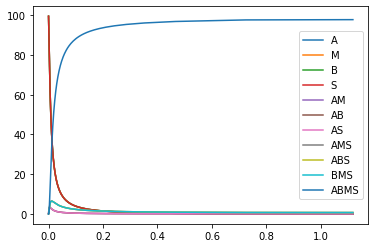

In [21]:
optim.plot_observable(-1,nodes_list)


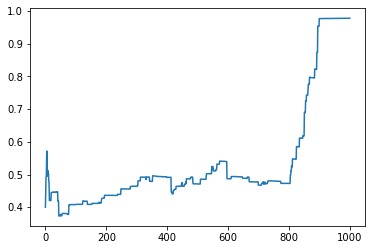

In [22]:
optim.plot_yield()

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

No handles with labels found to put in legend.


Using CPU
Start of simulation: memory Used:  92.1
Next time:  tensor(3.1128, dtype=torch.float64, grad_fn=<AddBackward0>)
Using CPU
Start of simulation: memory Used:  92.1


No handles with labels found to put in legend.


Next time:  tensor(12266.4719, dtype=torch.float64, grad_fn=<AddBackward0>)
Using CPU
Start of simulation: memory Used:  92.1
Next time:  tensor(12266.4719, dtype=torch.float64, grad_fn=<AddBackward0>)
{'A': 0, 'M': 1, 'B': 2, 'S': 3, 'AM': 4, 'AB': 5, 'AS': 6, 'BM': 7, 'MS': 8, 'ABM': 9, 'AMS': 10, 'BS': 11, 'ABS': 12, 'BMS': 13, 'ABMS': 14}


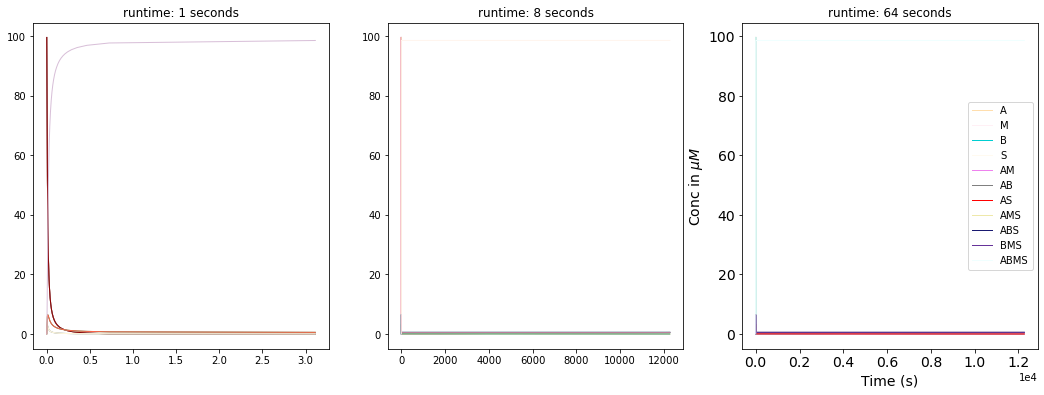

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3)
optim_rn = optim.rn
for i, runtime in enumerate([1, 8, 64]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i],)
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
plt.show()

In [24]:
node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

{'A': 0, 'M': 1, 'B': 2, 'S': 3, 'AM': 4, 'AB': 5, 'AS': 6, 'BM': 7, 'MS': 8, 'ABM': 9, 'AMS': 10, 'BS': 11, 'ABS': 12, 'BMS': 13, 'ABMS': 14}
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + M  ->  AM
Net flux:  tensor([-0.0598], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.2372], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
Reaction:  A + B  ->  AB
Net flux:  tensor([-0.0598], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(0.2393, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.2372], dtype=torch.float64, grad_fn=<ExpBackward>)
Reacti

In [25]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

ABMS  :  tensor([-1116.3784], dtype=torch.float64, grad_fn=<AddBackward0>)
AS  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
AM  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
BS  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
MS  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
BM  :  tensor([2.7546], dtype=torch.float64, grad_fn=<AddBackward0>)
BMS  :  tensor([275.0524], dtype=torch.float64, grad_fn=<AddBackward0>)
ABM  :  tensor([275.0524], dtype=torch.float64, grad_fn=<AddBackward0>)
AMS  :  tensor([275.0524], dtype=torch.float64, grad_fn=<AddBackward0>)
ABS  :  tensor([275.0524], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([282.9573], dtype=torch.float64, grad_fn=<AddBackward0>)
M  :  tensor([282.9573], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([282.9573], dtype=torch.float64, grad_fn=<AddBackward0>)
S  :  tensor(

In [26]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

NameError: name 'solution' is not defined

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 